In [ ]:
import tensorflow as tf
import numpy as np

# helpers
def spins_to_tensor(spins):
    # make sure dtype and shape (batch, L, 1)
    return tf.convert_to_tensor(spins, dtype=tf.float32)

@tf.function
def metropolis_sample_tf(model, initial_config, n_walkers, n_steps=100):
    """
    Vectorized Metropolis-Hastings over n_walkers in parallel.
    initial_config: shape (L,1) or (L,), dtype float32 values in {-1, +1}
    Returns: tensor shape (n_walkers, L, 1)
    """
    # prepare walkers: tile initial config
    init = tf.reshape(tf.convert_to_tensor(initial_config, dtype=tf.float32), (1, -1, 1))
    L = tf.shape(init)[1]
    configs = tf.repeat(init, repeats=n_walkers, axis=0)  # (n_walkers, L, 1)

    # compute initial log_psi for each walker
    log_psi = tf.reshape(model(configs, training=False), (n_walkers,))  # (n_walkers,)

    for _ in tf.range(n_steps):
        # choose sites to propose flip for each walker
        idx = tf.random.uniform((n_walkers,), minval=0, maxval=L, dtype=tf.int32)  # (n_walkers,)
        one_hot = tf.one_hot(idx, L, dtype=tf.float32)  # (n_walkers, L)
        mult = 1.0 - 2.0 * one_hot  # -1 at chosen pos, 1 elsewhere
        mult = tf.reshape(mult, (n_walkers, L, 1))  # (n_walkers, L, 1)
        proposed = configs * mult  # flip selected spin for each walker

        # evaluate log_psi proposed
        log_psi_prop = tf.reshape(model(proposed, training=False), (n_walkers,))  # (n_walkers,)

        # acceptance prob for |psi|^2: min(1, exp(2*(log_psi_prop - log_psi)))
        log_ratio = 2.0 * (log_psi_prop - log_psi)
        accept_prob = tf.exp(tf.clip_by_value(log_ratio, -50.0, 50.0))  # clip for stability
        accept = tf.random.uniform((n_walkers,)) < tf.minimum(accept_prob, 1.0)

        # where accepted, update configs and log_psi
        accept = tf.reshape(tf.cast(accept, tf.float32), (n_walkers, 1, 1))
        configs = tf.where(accept > 0.5, proposed, configs)
        log_psi = tf.where(tf.reshape(tf.cast(accept > 0.5, tf.bool), (n_walkers,)), log_psi_prop, log_psi)

    return configs  # (n_walkers, L, 1)


@tf.function
def local_energy_tf(model, samples, J, h):
    """
    Vectorized local energy computation.
    samples: (n_samples, L, 1) with values +/-1
    Returns: eloc tensor shape (n_samples,)
    """
    samples = tf.cast(samples, tf.float32)
    n_samples = tf.shape(samples)[0]
    L = tf.shape(samples)[1]

    # compute log_psi for original batch
    log_psi = tf.reshape(model(samples, training=False), (n_samples,))  # (n_samples,)

    # diagonal term: -J sum sigma_i sigma_{i+1}
    s = tf.reshape(samples, (n_samples, L))
    s_next = tf.roll(s, -1, axis=1)
    diag_energy = -J * tf.reduce_sum(s * s_next, axis=1)  # (n_samples,)

    # off-diagonal: single-spin flips
    # multipliers: (L, L) matrix, each row flips a single position
    # multipliers[k] = vector of length L with -1 at k, 1 else
    I = tf.eye(L, dtype=tf.float32)
    multipliers = 1.0 - 2.0 * I  # shape (L, L)

    # expand samples to shape (n_samples, L, L, 1) via broadcasting:
    # samples[:, None, :, :] -> (n_samples, 1, L, 1) ; multipliers[None, :, :, None] -> (1, L, L, 1)
    samples_exp = tf.reshape(samples, (n_samples, 1, L, 1))
    mult_exp = tf.reshape(multipliers, (1, L, L, 1))
    flipped = samples_exp * mult_exp  # (n_samples, L, L, 1)

    # reshape to (n_samples * L, L, 1) to evaluate model in one batch
    flipped_reshaped = tf.reshape(flipped, (n_samples * L, L, 1))

    # evaluate log_psi for all single-flip configs
    log_psi_flips = tf.reshape(model(flipped_reshaped, training=False), (n_samples, L))  # (n_samples, L)

    # ratio psi_prime / psi = exp(log_psi_prime - log_psi[:, None])
    ratio = tf.exp(tf.clip_by_value(log_psi_flips - tf.reshape(log_psi, (n_samples, 1)), -50.0, 50.0))

    # off-diagonal local energy: sum over flips of (-h) * (psi_prime/psi)
    off_diag = -h * tf.reduce_sum(ratio, axis=1)  # (n_samples,)

    eloc = diag_energy + off_diag  # (n_samples,)
    return eloc, log_psi


@tf.function
def vmc_training_step_tf(model, optimizer, samples, J, h):
    
    """
    One VMC gradient step (vectorized).
    samples: tensor (n_samples, L, 1)
    """
    samples = tf.cast(samples, tf.float32)
    with tf.GradientTape() as tape:
        eloc, log_psi = local_energy_tf(model, samples, J, h)  # eloc: (n_samples,)
        E_mean = tf.reduce_mean(eloc)
        # VMC loss: 2 * mean( (E_loc - E_mean) * log_psi )
        # Note: E_loc typically treated as constant for gradient (stop gradient)
        loss = 2.0 * tf.reduce_mean((tf.stop_gradient(eloc) - E_mean) * log_psi)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return E_mean, loss


In [2]:

from tensorflow import keras

import matplotlib.pyplot as plt

callbacks = keras.callbacks
layers = keras.layers
rng = np.random.default_rng()
print("keras", keras.__version__)

keras 3.6.0


In [3]:
L = 14
J = 1.0
h = 1.0
nqs = keras.models.Sequential([
    layers.Input(shape=(L,1 )),
    layers.Flatten(),
    layers.Dense(160,activation='relu'),
    layers.Dense(100, activation='tanh'),
    layers.Dense(200, activation='relu'),
    
    layers.Dropout(0.3),
    layers.Dense(160, activation='relu'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation=None)
])
nqs.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 160)            │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        16,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 160)            │        32,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         1,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,713 (303.57 KB)

 Trainable params: 77,713 (303.57 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
def init_lat(lx,ly):
    rng = np.random.default_rng()
    lattice = 2 * (0.5 - rng.integers(0, 2, size=(lx, ly)))
    return lattice

In [6]:

n_samples = 500
initial_config = np.array(init_lat(L,1), dtype=np.float32)  # shape: (L,1)
initial_config.shape

(14, 1)

In [7]:
initial_config_tf = tf.convert_to_tensor(initial_config, dtype=tf.float32)
num_epochs= 100
lr = 0.001
optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr)
samples_tf = metropolis_sample_tf(nqs, initial_config_tf, n_walkers=n_samples, n_steps=100)
e,l =vmc_training_step_tf(nqs, optimizer, samples_tf, J, h)
E=[e]
lss_val=[l]


In [23]:
# convert initial_config to tf format, e.g. shape (L,1)
num_epochs= 100
n_samples = 1000
lr = 1e-6
#optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr)
for epoch in range(num_epochs):
    # generate n_samples parallel walkers; pick n_steps per walker to decorrelate
    samples_tf = metropolis_sample_tf(nqs, initial_config_tf, n_walkers=n_samples, n_steps=100)
    # run a vectorized training step
    E_avg_tf, loss_tf = vmc_training_step_tf(nqs, optimizer, samples_tf, J, h)
    if np.mod(epoch,10)==0:
        E.append(float(E_avg_tf.numpy()))
        lss_val.append(float(loss_tf.numpy()))
    print(f"Epoch {epoch+1}: Energy = {float(E_avg_tf):.6f}, Loss = {float(loss_tf):.6f}")

    # update initial_config for next epoch: pick one walker (convert to numpy)
    initial_config_tf = tf.expand_dims(samples_tf[-1], 0)  # shape (1, L, 1)
    initial_config = initial_config_tf[0].numpy()  # if you want numpy copy


Epoch 1: Energy = -17.806454, Loss = 0.112682
Epoch 2: Energy = -17.729324, Loss = -0.095629
Epoch 3: Energy = -17.757448, Loss = 0.129032
Epoch 4: Energy = -17.790148, Loss = 0.211433
Epoch 5: Energy = -17.718731, Loss = -0.297854
Epoch 6: Energy = -17.710072, Loss = -0.309667
Epoch 7: Energy = -17.719645, Loss = -0.236453
Epoch 8: Energy = -17.752363, Loss = -0.174250
Epoch 9: Energy = -17.719702, Loss = -0.030758
Epoch 10: Energy = -17.706770, Loss = -0.113249
Epoch 11: Energy = -17.686552, Loss = -0.266163
Epoch 12: Energy = -17.678696, Loss = -0.201774
Epoch 13: Energy = -17.732784, Loss = 0.023039
Epoch 14: Energy = -17.687960, Loss = -0.362502
Epoch 15: Energy = -17.763731, Loss = 0.129794
Epoch 16: Energy = -17.721773, Loss = -0.086432
Epoch 17: Energy = -17.736080, Loss = -0.038126
Epoch 18: Energy = -17.704542, Loss = -0.229974
Epoch 19: Energy = -17.715540, Loss = -0.140609
Epoch 20: Energy = -17.699427, Loss = -0.181578
Epoch 21: Energy = -17.685282, Loss = -0.324507
Epoch 

In [9]:
E_ed_14 =-17.86280854
E_ed_24=-30.19971233

In [19]:
del_e_24 =[i+30.19971233 for i in E]

In [10]:
del_e_14 =[i+17.47100405 for i in E]

In [24]:
e = []
for i in range(100):
    samples_tf = metropolis_sample_tf(nqs, initial_config_tf, n_walkers=1000, n_steps=100)
    loc_e = local_energy_tf(nqs,samples_tf,J,h)
    pred_E_gs = np.mean(loc_e[0])
    e.append(pred_E_gs)
pred_E_gs = np.mean(e)
pred_E_gs


-17.73028

In [17]:
yerror= np.array(e)-E_ed_14

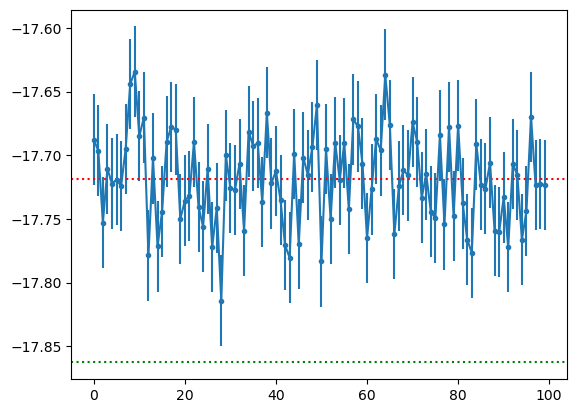

In [20]:
plt.errorbar(range(len(e)),e,yerr=np.std(e), fmt='.-')
plt.axhline(pred_E_gs,c='r',linestyle=':')
plt.axhline(E_ed_14,c='g',linestyle=':')
plt.show()

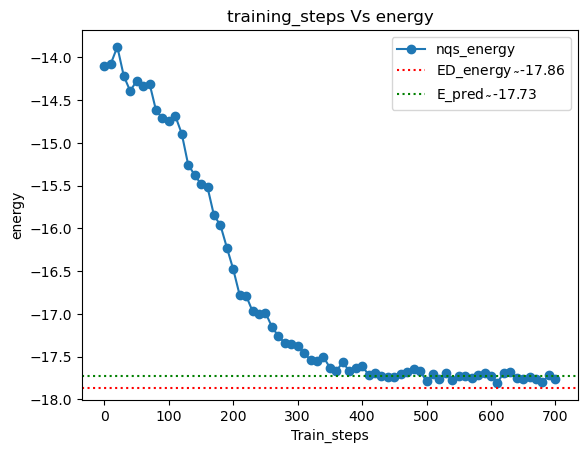

In [25]:
plt.plot(range(0,10*len(E),10),E,'o-', label = 'nqs_energy')
plt.xlabel('Train_steps')
plt.ylabel('energy')
plt.title('training_steps Vs energy')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0,30)
#plt.ylim(0,2)
plt.axhline(E_ed_14,ls=':',c='r', label=rf'ED_energy $ \tilde{{}} $ {E_ed_14:.2f}')
plt.axhline(pred_E_gs,ls=':',c='g', label=rf'E_pred $ \tilde{{}} $ {pred_E_gs:.2f}')
plt.legend()
#plt.savefig('ener_tf_L24')

plt.show()

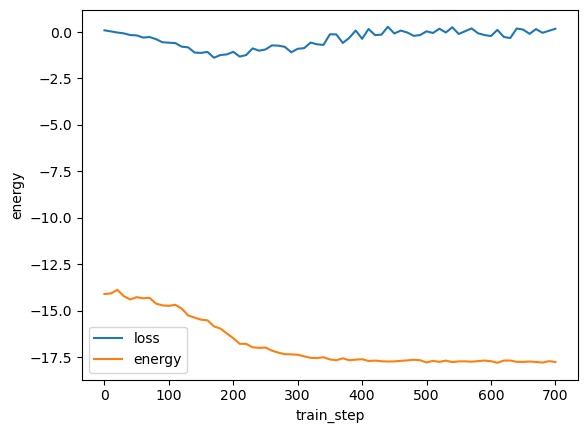

In [26]:
plt.plot(range(0,10*len(E),10),lss_val,label='loss')
plt.plot(range(0,10*len(E),10),E,label='energy')
plt.xlabel('train_step')
plt.ylabel('energy')
plt.legend()
#plt.savefig('loss_tf_L24')
plt.show()

In [33]:

samples_tf = metropolis_sample_tf(nqs, initial_config_tf, n_walkers=n_samples, n_steps=50)



In [83]:
loc_e = local_energy_tf(nqs,samples_tf,J,h)
np.mean(loc_e[0])

-30.220684

In [82]:
def dec_bin(i, num_bits=None):
    bin_str = bin(i)[2:] 
    if num_bits:
        bin_str = bin_str.zfill(num_bits)
    return np.array(list(bin_str), dtype=int)
x_in = []
for i in range(2**L):
    a = dec_bin(i,L)
    x_in.append(a)

In [ ]:
a = [(nqs(np.reshape(x_in[i],(1,-1,1)),
                training= False)).numpy()[0][0] for i in range(2**L)]

In [ ]:
np.linalg.norm(a)

In [30]:
b=nqs(np.reshape(x_in[0],(1,-1,1)),training=False).numpy()

In [31]:
(a[0][0])

-0.7476981

In [ ]:
len(a)

In [ ]:
plt.plot(range(len(a)),a)